# Pseudo Ray Tracing
| Author  | Stanley A. Baronett  |
|---------|----------------------|
| Created |  10/30/2023          |
| Updated |  11/06/2023          |

## [Quantities](https://github.com/PrincetonUniversity/athena/wiki/Non-relativistic-Radiation-Transport#units)

- Code Units
  - Temperature $T_0$
  - Density $\rho_0$
  - Length $L_0$
  - Time $t_0 = L_0 / v_0 = \mathbb{C}L_0 / c$
- Ideal Gas
  - Constant mean molecular weight $\mu$
  - Velocity $v_0 = \sqrt{k_\mathrm{B} T_0 / (\mu m_\mathrm{p})}$
  - Pressure $P_0 \equiv k_\mathrm{B}\rho_0 T_0 / (\mu m_\mathrm{p})$
  - Internal energy $E_\mathrm{g} = P/(\gamma_\mathrm{g} - 1)$ for adiabatic index $\gamma_\mathrm{g} \neq 1$
  - Temperature $T = P/(R_\mathrm{ideal}\rho) = E_\mathrm{g}(\gamma_\mathrm{g} - 1)/(R_\mathrm{ideal}\rho)$
- Radiation
  - Specific intensity $I\,[a_\mathrm{r}T_0^4]$
  - Energy density $E_\mathrm{r} = \int I\mathrm{d}\Omega$ (taking $4\pi = 1$)
  - Flux $\mathbf{F}_\mathrm{r} = \int\mathbf{n}I\mathrm{d}\Omega$ (units of $ca_\mathrm{r}T_0^4$)
- Dimensionless
  - $\mathbb{C} = \mathcal{C} \equiv c/v_0$
  - $\mathbb{P} = \mathcal{P} \equiv a_\mathrm{r}T_0^4 / P_0 = a_\mathrm{r}T_0^4 / (\rho_0 R_\mathrm{ideal} T_0)$
- Sums
  - Total pressure (energy) $P_\mathrm{g} + \mathbb{P}P_\mathrm{r}\,[P_0]$
  - Total momentum $\rho v + F_\mathrm{r}\mathbb{P}/\mathbb{C}\,[\rho_0 v_0]$

## Stellar Properties

The luminosity $L = FA$, where $F$ is the flux and $A$ is the emission surface area.
For an emitting sphere with radius $R$, and $F = \sigma T^4$ (Rybicki & Lightman 1979, eq. 1.43),

$$
  L = \sigma T^4(4\pi R^2).
$$

In [1]:
#===============================================================================
import numpy as np

# athinput.stellar_flux
# <radiation>
T_unit       = 6.14e3              # T_0 [K]
length_unit  = 5.98e14             # L_0 [cm]

# <problem>
R            = 1.16e-4             # solar radius [L_0]
T            = 9.42e-1             # solar temperature [T_0]
# end athinput.stellar_flux

# physical constants, units
sigma        = 5.67e-5             # [erg/s/cm^2/K^4]
Lsun         = 3.83e33             # [erg/s]
au           = 1.495978707e13      # [cm]
L_au         = length_unit/au      # [au]

Flux = lambda r : sigma*(T*T_unit)**4*(R/r)**2 # stellar flux at distance r
A = 4*np.pi*(R*length_unit)**2                 # stellar surface area [cm^2]
L = Flux(R)*A                                  # stellar luminosity

print(f'       T = {T*T_unit:.0f} K')
print(f'       L = {L/Lsun:.1f} Lsun')
print(f'F( 1 au) = {Flux(1/L_au):.1e} erg/cm^2/s'\
      + f'= {Flux(1/L_au)/1e3:.0f} W/m^2 (solar constant)')
print(f'F(10 au) = {Flux(10/L_au):.1e} erg/cm^2/s'\
      + f'= {Flux(10/L_au)/1e3:.2f} W/m^2')
# Flux at Saturn (~10 au) https://astronomy.stackexchange.com/a/25242/33232

       T = 5784 K
       L = 1.0 Lsun
F( 1 au) = 1.4e+06 erg/cm^2/s= 1364 W/m^2 (solar constant)
F(10 au) = 1.4e+04 erg/cm^2/s= 13.64 W/m^2


## Analytic Solution

### Dust Density Profile

See [Desmos](https://www.desmos.com/) for interactive plots of 
- [$\rho_\mathrm{mid}$](https://www.desmos.com/calculator/ubtsqj1ltb)
- [$\rho(\theta)$](https://www.desmos.com/calculator/marlugmhhr)

\begin{align*}
  \frac{P(r, \theta)}{r} &= \frac{P_0}{r_0}\left(\frac{r\sin\theta}{r_0}\right)^{-1/2} \\
  \rho_\mathrm{mid}(r, \theta) &= \frac{\rho_0\left(\frac{r\sin\theta + r_0}{r_0}\right)^{-9/4}}{1 + \exp\left[-e^e\left(\frac{r\sin\theta - r_0}{r_0}\right)\right]} \\
  \rho(r, \theta) &= \rho_\mathrm{mid}\exp\left[\frac{GMr}{P}\left(\frac{1}{\sqrt{r^2\sin^2\theta + r^2\cos^2\theta}} - \frac{1}{r\sin\theta}\right)\right] \\
                  &= \rho_\mathrm{mid}\exp\left[\frac{GM}{P}\left(1 - \frac{1}{\sin\theta}\right)\right] \\
\end{align*}

κ_a = 558.98169599999994 rho0*L_0


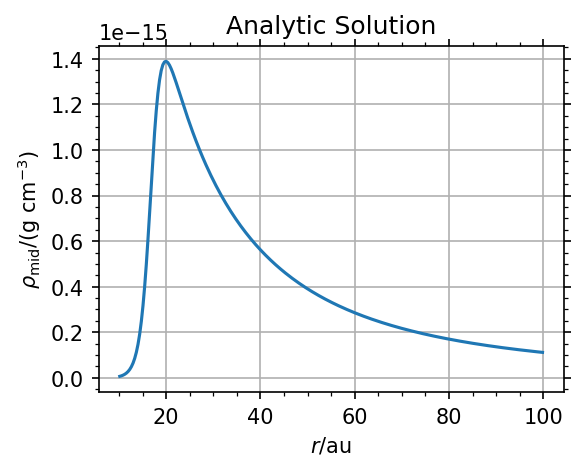

In [2]:
#===============================================================================
import numpy as np
import matplotlib.pyplot as plt

# begin stellar_flux.cpp
# void Mesh::InitUserMeshData(ParameterInput *pin) {
# // Get parameters for gravitatonal potential of central point mass
gm0 = 1.0 # pin->GetOrAddReal("problem","GM",0.0);

# //---------------------------------------------------------------------------
# //! transform to cylindrical coordinate

def GetCylCoord(x1, x2, x3):
  rad = x1*np.sin(x2)
  phi = x3
  z = x1*np.cos(x2)
  return rad, phi, z

# //---------------------------------------------------------------------------
# //! computes density in cylindrical coordinates

def DenProfileCyl(x1, x2, x3):
  rad, phi, z, = GetCylCoord(x1, x2, x3)
  p_over_r = PoverR(rad, phi, z)
  denmid = rho0*np.power((rad + r0)/r0, dslope)\
           /(1 + np.exp(-np.exp(np.e)*(rad - r0)/r0))
  dentem = denmid*np.exp(gm0/p_over_r*(1./np.sqrt(rad**2 + z**2) - 1./rad))
  den = dentem
  return den

# //---------------------------------------------------------------------------
# //! computes pressure/density in cylindrical coordinates

def PoverR(rad, phi, z):
  poverr = p0_over_r0*np.power(rad/r0, pslope)
  return poverr
# end stellar_flux.cpp

# extra quantities
kappa_star_cgs    = 10             # [cm^2/g]
dgratio           = 100            # dust-to-gas ratio
small_grain_ratio = 0.02184

# begin athinput.stellar_flux
# <mesh>
nx1          = 256                 # Number of zones in X1-direction
x1min        = 0.250163663377926   # minimum value of X1
x1max        = 2.501636633779264   # maximum value of X1

nx2          = 512                 # Number of zones in X2-direction
x2min        = 0                   # minimum value of X2
x2max        = 3.141592653589793   # maximum value of X2

# <hydro>
dfloor       = 1e-12               # minimum density

# <radiation>
prat         = 1.13e3              # $a_rT_0^4/P_0$
crat         = 6.36e4              # $c/v_0$
T_unit       = 6.14e3              # T_0 [K]
density_unit = 4.28e-14            # \rho_0 [g/cm^3]
length_unit  = 5.98e14             # L_0 [cm]

# <problem>
r0           = 0.425278227742474   # radial normalization (17/L_au)
rho0         = 0.2                 # [\rho_0]
p0_over_r0   = 4.80e-03
pslope       = -0.5                # pressure power-law index
dslope       = -2.25               # density power-law index
kappa_a      = 558.98169599999994  # absorption opacity
R            = 1.16e-4             # stellar radius [L_0]
T            = 9.42e-1             # stellar temperature [T_0]
# end athinput.stellar_flux

kappa_star = kappa_star_cgs*dgratio*small_grain_ratio*density_unit*length_unit
print(f'κ_a = {kappa_star:.14f} rho0*L_0')

# conversions
au           = 1.495978707e13      # [cm]
L_au         = length_unit/au      # [au]
rad2deg      = 180/np.pi

# Construct mesh
x1f, x2f = np.linspace(x1min, x1max, nx1+1), np.linspace(x2min, x2max, nx2+1)
x1v, x2v = (x1f[:-1] + x1f[1:])/2, (x2f[:-1] + x2f[1:])/2
x1mesh, x2mesh = np.meshgrid(x1v, x2v)
rho_field = DenProfileCyl(x1mesh, x2mesh, 0)
rho_field[rho_field < dfloor] = dfloor
dtheta = (x2max - x2min)/nx2
theta_mid_deg = 90
j_mid = int(theta_mid_deg/rad2deg/dtheta)

# Plot
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
ax.plot(x1v*L_au, rho_field[j_mid, :]*density_unit)

# Format (sub)plots
ax.grid()
ax.minorticks_on()
ax.set(title='Analytic Solution', xlabel='$r$/au',
       ylabel=r'$\rho_\mathrm{mid}$/(g cm$^{-3}$)')
ax.tick_params(axis='both', which='both', top=True, right=True)
# plt.savefig('figs/frame.jpg', bbox_inches='tight')

κ_a = 558.98169599999994 rho0*L_0


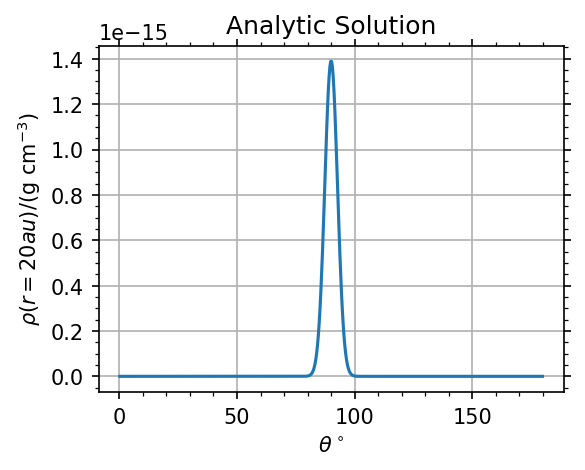

In [3]:
#===============================================================================
import numpy as np
import matplotlib.pyplot as plt

# begin stellar_flux.cpp
# void Mesh::InitUserMeshData(ParameterInput *pin) {
# // Get parameters for gravitatonal potential of central point mass
gm0 = 1.0 # pin->GetOrAddReal("problem","GM",0.0);

# //---------------------------------------------------------------------------
# //! transform to cylindrical coordinate

def GetCylCoord(x1, x2, x3):
  rad = x1*np.sin(x2)
  phi = x3
  z = x1*np.cos(x2)
  return rad, phi, z

# //---------------------------------------------------------------------------
# //! computes density in cylindrical coordinates

def DenProfileCyl(x1, x2, x3):
  rad, phi, z, = GetCylCoord(x1, x2, x3)
  p_over_r = PoverR(rad, phi, z)
  denmid = rho0*np.power((rad + r0)/r0, dslope)\
           /(1 + np.exp(-np.exp(np.e)*(rad - r0)/r0))
  dentem = denmid*np.exp(gm0/p_over_r*(1./np.sqrt(rad**2 + z**2) - 1./rad))
  den = dentem
  return den

# //---------------------------------------------------------------------------
# //! computes pressure/density in cylindrical coordinates

def PoverR(rad, phi, z):
  poverr = p0_over_r0*np.power(rad/r0, pslope)
  return poverr
# end stellar_flux.cpp

# extra quantities
kappa_star_cgs    = 10             # [cm^2/g]
dgratio           = 100            # dust-to-gas ratio
small_grain_ratio = 0.02184

# begin athinput.stellar_flux
# <mesh>
nx1          = 256                 # Number of zones in X1-direction
x1min        = 0.250163663377926   # minimum value of X1
x1max        = 2.501636633779264   # maximum value of X1

nx2          = 512                 # Number of zones in X2-direction
x2min        = 0                   # minimum value of X2
x2max        = 3.141592653589793   # maximum value of X2

# <hydro>
dfloor       = 1e-12               # minimum density

# <radiation>
prat         = 1.13e3              # $a_rT_0^4/P_0$
crat         = 6.36e4              # $c/v_0$
T_unit       = 6.14e3              # T_0 [K]
density_unit = 4.28e-14            # \rho_0 [g/cm^3]
length_unit  = 5.98e14             # L_0 [cm]

# <problem>
r0           = 0.425278227742474   # radial normalization (17/L_au)
rho0         = 0.2                 # [\rho_0]
p0_over_r0   = 4.80e-03
pslope       = -0.5                # pressure power-law index
dslope       = -2.25               # density power-law index
kappa_a      = 558.98169599999994  # absorption opacity
R            = 1.16e-4             # stellar radius [L_0]
T            = 9.42e-1             # stellar temperature [T_0]
# end athinput.stellar_flux

kappa_star = kappa_star_cgs*dgratio*small_grain_ratio*density_unit*length_unit
print(f'κ_a = {kappa_star:.14f} rho0*L_0')

# conversions
au           = 1.495978707e13      # [cm]
L_au         = length_unit/au      # [au]
rad2deg      = 180/np.pi

# Construct mesh
x1f, x2f = np.linspace(x1min, x1max, nx1+1), np.linspace(x2min, x2max, nx2+1)
x1v, x2v = (x1f[:-1] + x1f[1:])/2, (x2f[:-1] + x2f[1:])/2
x1mesh, x2mesh = np.meshgrid(x1v, x2v)
rho_field = DenProfileCyl(x1mesh, x2mesh, 0)
rho_field[rho_field < dfloor] = dfloor

# Plot
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
dx1 = (x1max - x1min)/nx1
ax.plot(x2v*rad2deg, rho_field[:, int(10/L_au/dx1)]*density_unit) # x1min offset

# Format (sub)plots
ax.grid()
ax.minorticks_on()
ax.set(title='Analytic Solution', xlabel=r'$\theta^\circ$',
       ylabel=r'$\rho(r=20au)$/(g cm$^{-3}$)')
ax.tick_params(axis='both', which='both', top=True, right=True)
# plt.savefig('figs/frame.jpg', bbox_inches='tight')

κ_a = 558.98169599999994 rho0*L_0


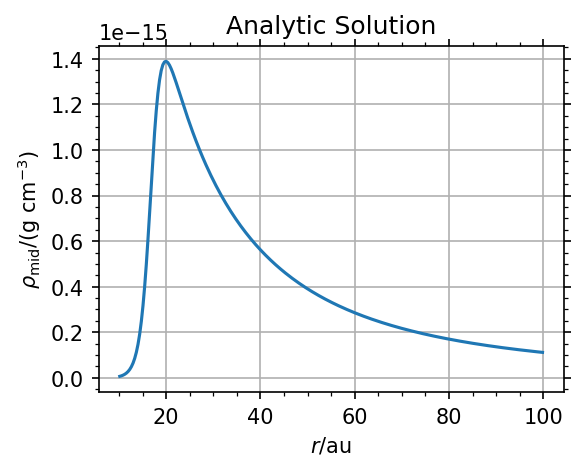

In [4]:
#===============================================================================
import numpy as np
import matplotlib.pyplot as plt

# begin stellar_flux.cpp
# void Mesh::InitUserMeshData(ParameterInput *pin) {
# // Get parameters for gravitatonal potential of central point mass
gm0 = 1.0 # pin->GetOrAddReal("problem","GM",0.0);

# //---------------------------------------------------------------------------
# //! transform to cylindrical coordinate

def GetCylCoord(x1, x2, x3):
  rad = x1*np.sin(x2)
  phi = x3
  z = x1*np.cos(x2)
  return rad, phi, z

# //---------------------------------------------------------------------------
# //! computes density in cylindrical coordinates

def DenProfileCyl(x1, x2, x3):
  rad, phi, z, = GetCylCoord(x1, x2, x3)
  p_over_r = PoverR(rad, phi, z)
  denmid = rho0*np.power((rad + r0)/r0, dslope)\
           /(1 + np.exp(-np.exp(np.e)*(rad - r0)/r0))
  dentem = denmid*np.exp(gm0/p_over_r*(1./np.sqrt(rad**2 + z**2) - 1./rad))
  den = dentem
  return den

# //---------------------------------------------------------------------------
# //! computes pressure/density in cylindrical coordinates

def PoverR(rad, phi, z):
  poverr = p0_over_r0*np.power(rad/r0, pslope)
  return poverr
# end stellar_flux.cpp

# extra quantities
kappa_star_cgs    = 10             # [cm^2/g]
dgratio           = 100            # dust-to-gas ratio
small_grain_ratio = 0.02184

# begin athinput.stellar_flux
# <mesh>
nx1          = 256                 # Number of zones in X1-direction
x1min        = 0.250163663377926   # minimum value of X1
x1max        = 2.501636633779264   # maximum value of X1

nx2          = 512                 # Number of zones in X2-direction
x2min        = 0                   # minimum value of X2
x2max        = 3.141592653589793   # maximum value of X2

# <hydro>
dfloor       = 1e-12               # minimum density

# <radiation>
prat         = 1.13e3              # $a_rT_0^4/P_0$
crat         = 6.36e4              # $c/v_0$
T_unit       = 6.14e3              # T_0 [K]
density_unit = 4.28e-14            # \rho_0 [g/cm^3]
length_unit  = 5.98e14             # L_0 [cm]

# <problem>
r0           = 0.425278227742474   # radial normalization (17/L_au)
rho0         = 0.2                 # [\rho_0]
p0_over_r0   = 4.80e-03
pslope       = -0.5                # pressure power-law index
dslope       = -2.25               # density power-law index
kappa_a      = 558.98169599999994  # absorption opacity
R            = 1.16e-4             # stellar radius [L_0]
T            = 9.42e-1             # stellar temperature [T_0]
# end athinput.stellar_flux

kappa_star = kappa_star_cgs*dgratio*small_grain_ratio*density_unit*length_unit
print(f'κ_a = {kappa_star:.14f} rho0*L_0')

# conversions
au           = 1.495978707e13      # [cm]
L_au         = length_unit/au      # [au]
rad2deg      = 180/np.pi

# Construct mesh
x1f, x2f = np.linspace(x1min, x1max, nx1+1), np.linspace(x2min, x2max, nx2+1)
x1v, x2v = (x1f[:-1] + x1f[1:])/2, (x2f[:-1] + x2f[1:])/2
x1mesh, x2mesh = np.meshgrid(x1v, x2v)
rho_field = DenProfileCyl(x1mesh, x2mesh, 0)
rho_field[rho_field < dfloor] = dfloor
dtheta = (x2max - x2min)/nx2
theta_mid_deg = 90
j_mid = int(theta_mid_deg/rad2deg/dtheta)

# Plot
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
ax.plot(x1v*L_au, rho_field[j_mid, :]*density_unit)

# Format (sub)plots
ax.grid()
ax.minorticks_on()
ax.set(title='Analytic Solution', xlabel='$r$/au',
       ylabel=r'$\rho_\mathrm{mid}$/(g cm$^{-3}$)')
ax.tick_params(axis='both', which='both', top=True, right=True)
# plt.savefig('figs/frame.jpg', bbox_inches='tight')

κ_a = 558.98169599999994 rho0*L_0


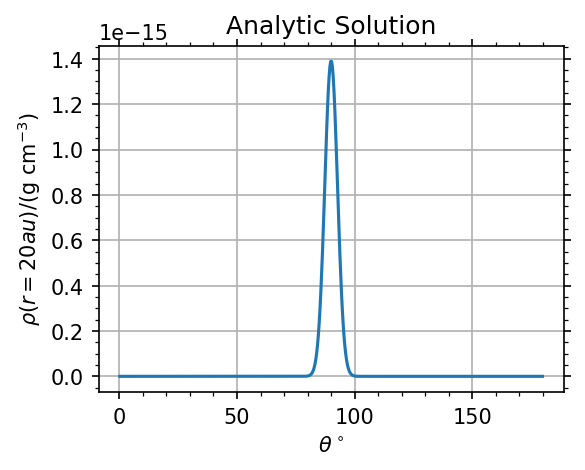

In [5]:
#===============================================================================
import numpy as np
import matplotlib.pyplot as plt

# begin stellar_flux.cpp
# void Mesh::InitUserMeshData(ParameterInput *pin) {
# // Get parameters for gravitatonal potential of central point mass
gm0 = 1.0 # pin->GetOrAddReal("problem","GM",0.0);

# //---------------------------------------------------------------------------
# //! transform to cylindrical coordinate

def GetCylCoord(x1, x2, x3):
  rad = x1*np.sin(x2)
  phi = x3
  z = x1*np.cos(x2)
  return rad, phi, z

# //---------------------------------------------------------------------------
# //! computes density in cylindrical coordinates

def DenProfileCyl(x1, x2, x3):
  rad, phi, z, = GetCylCoord(x1, x2, x3)
  p_over_r = PoverR(rad, phi, z)
  denmid = rho0*np.power((rad + r0)/r0, dslope)\
           /(1 + np.exp(-np.exp(np.e)*(rad - r0)/r0))
  dentem = denmid*np.exp(gm0/p_over_r*(1./np.sqrt(rad**2 + z**2) - 1./rad))
  den = dentem
  return den

# //---------------------------------------------------------------------------
# //! computes pressure/density in cylindrical coordinates

def PoverR(rad, phi, z):
  poverr = p0_over_r0*np.power(rad/r0, pslope)
  return poverr
# end stellar_flux.cpp

# extra quantities
kappa_star_cgs    = 10             # [cm^2/g]
dgratio           = 100            # dust-to-gas ratio
small_grain_ratio = 0.02184

# begin athinput.stellar_flux
# <mesh>
nx1          = 256                 # Number of zones in X1-direction
x1min        = 0.250163663377926   # minimum value of X1
x1max        = 2.501636633779264   # maximum value of X1

nx2          = 512                 # Number of zones in X2-direction
x2min        = 0                   # minimum value of X2
x2max        = 3.141592653589793   # maximum value of X2

# <hydro>
dfloor       = 1e-12               # minimum density

# <radiation>
prat         = 1.13e3              # $a_rT_0^4/P_0$
crat         = 6.36e4              # $c/v_0$
T_unit       = 6.14e3              # T_0 [K]
density_unit = 4.28e-14            # \rho_0 [g/cm^3]
length_unit  = 5.98e14             # L_0 [cm]

# <problem>
r0           = 0.425278227742474   # radial normalization (17/L_au)
rho0         = 0.2                 # [\rho_0]
p0_over_r0   = 4.80e-03
pslope       = -0.5                # pressure power-law index
dslope       = -2.25               # density power-law index
kappa_a      = 558.98169599999994  # absorption opacity
R            = 1.16e-4             # stellar radius [L_0]
T            = 9.42e-1             # stellar temperature [T_0]
# end athinput.stellar_flux

kappa_star = kappa_star_cgs*dgratio*small_grain_ratio*density_unit*length_unit
print(f'κ_a = {kappa_star:.14f} rho0*L_0')

# conversions
au           = 1.495978707e13      # [cm]
L_au         = length_unit/au      # [au]
rad2deg      = 180/np.pi

# Construct mesh
x1f, x2f = np.linspace(x1min, x1max, nx1+1), np.linspace(x2min, x2max, nx2+1)
x1v, x2v = (x1f[:-1] + x1f[1:])/2, (x2f[:-1] + x2f[1:])/2
x1mesh, x2mesh = np.meshgrid(x1v, x2v)
rho_field = DenProfileCyl(x1mesh, x2mesh, 0)
rho_field[rho_field < dfloor] = dfloor

# Plot
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
dx1 = (x1max - x1min)/nx1
ax.plot(x2v*rad2deg, rho_field[:, int(10/L_au/dx1)]*density_unit) # x1min offset

# Format (sub)plots
ax.grid()
ax.minorticks_on()
ax.set(title='Analytic Solution', xlabel=r'$\theta^\circ$',
       ylabel=r'$\rho(r=20au)$/(g cm$^{-3}$)')
ax.tick_params(axis='both', which='both', top=True, right=True)
# plt.savefig('figs/frame.jpg', bbox_inches='tight')

### Optical Depth, Specific Intensity, Radial Flux

From Rybicki & Lightman (1979), we define the *optical depth* along a ray in the radial direction $r$ at polar angle $\theta$ as
\begin{align*}
  \mathrm{d}\tau &\equiv \alpha\mathrm{d}r \\
  \tau(r, \theta) &= \int_{r_0}^r \alpha(r', \theta)\mathrm{d}r', \tag{1.26}
\end{align*}
where we define the *absorption coefficient* $[\mathsf{L}^{-1}]$ as
$$
\alpha(r, \theta) \equiv \rho\kappa_\mathrm{a},
\tag{1.22}
$$
for mass density $\rho(r, \theta)$ and *opacity* coefficient $\kappa_\mathrm{a}$ $[\mathsf{L}^2\mathsf{M}^{-1}]$.
With these, we can express the radiative transfer equation (1.23)—for absorption only—in terms of the optical depth as
$$
  \frac{\mathrm{d}I}{\mathrm{d}\tau} = -I
$$
with the solution
$$
  I(\tau) = I(0)e^{-\tau}.
$$
For *blackbody radiation* from a surface of uniform brightness $B$ at temperature $T$ (Rybicki & Lightman 1979, eq. 1.42)
$$
  I(0) = B(T) = \frac{a_\mathrm{r}c}{4\pi}T^4.
$$
The flux $F$ at a radial distance $r$ from a sphere of uniform brightness $B$ and with radius $R$ is (cf. Rybicki & lightman 1979, eq. 1.13)
\begin{align*}
  F &= \pi B\left(\frac{R}{r}\right)^2e^{-\tau} \\
    &= \sigma T^4\left(\frac{R}{r}\right)^2e^{-\tau},
\end{align*}
where the Stefan–Boltzmann constant ($\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{K}^{-4}$) is defined as (Rybicki & lightman 1979, eq. 1.44a)
\begin{align*}
  \sigma &\equiv \frac{a_\mathrm{r}c}{4} \\
         &= \frac{\mathbb{P} P_0 \mathbb{C} v_0}{4T_0^4}.
\end{align*}

In [6]:
k_B = 1.38e-16  # Boltzmann constant [erg/K]
m_p = 1.67e-24  # proton mass [g]
mu = k_B*T_unit/m_p*(sigma*4*T_unit**4/prat/crat/rho0)**(-2/3)
P_0 = k_B*rho0*T_unit/mu/m_p
v_0 = np.sqrt(k_B*T_unit/mu/m_p)

print(f'μ = {mu:.2e}')
print(f'σ = {prat*P_0*crat*v_0/4/T_unit**4:.2e} erg/s/cm^2/K^4')

μ = 6.38e+08
σ = 5.67e-05 erg/s/cm^2/K^4


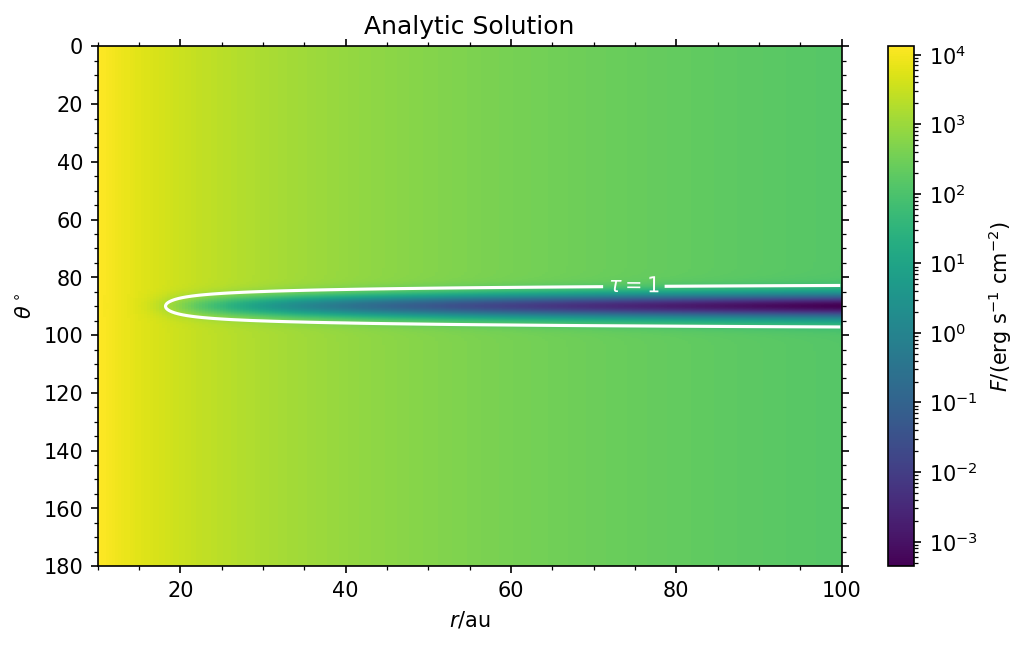

In [7]:
#===============================================================================
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt

def fmt(x):
  return rf'$\tau={x:.0f}$'

rad2deg = 180/np.pi
dr = (x1max - x1min)/nx1
dtau = rho_field*kappa_a*dr
tau  = np.cumsum(dtau, axis=1)
F = sigma*np.power(T*T_unit, 4)*np.power(R/x1v,2)*(np.exp(-tau))

# Plot and format
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=150)
im = ax.pcolormesh(x1v*L_au, x2v*rad2deg, F, norm=colors.LogNorm())
CS = ax.contour(x1v*L_au, x2v*rad2deg, tau, [1, 1e4],
                 colors=['white', 'white'])
plt.colorbar(im, label='$F$/(erg s$^{-1}$ cm$^{-2}$)')

ax.clabel(CS, CS.levels, fmt=fmt)
ax.invert_yaxis()
ax.minorticks_on()
ax.set(title='Analytic Solution', xlabel='$r$/au', ylabel=r'$\theta^\circ$')
ax.tick_params(axis='both', which='both', top=True, right=True)

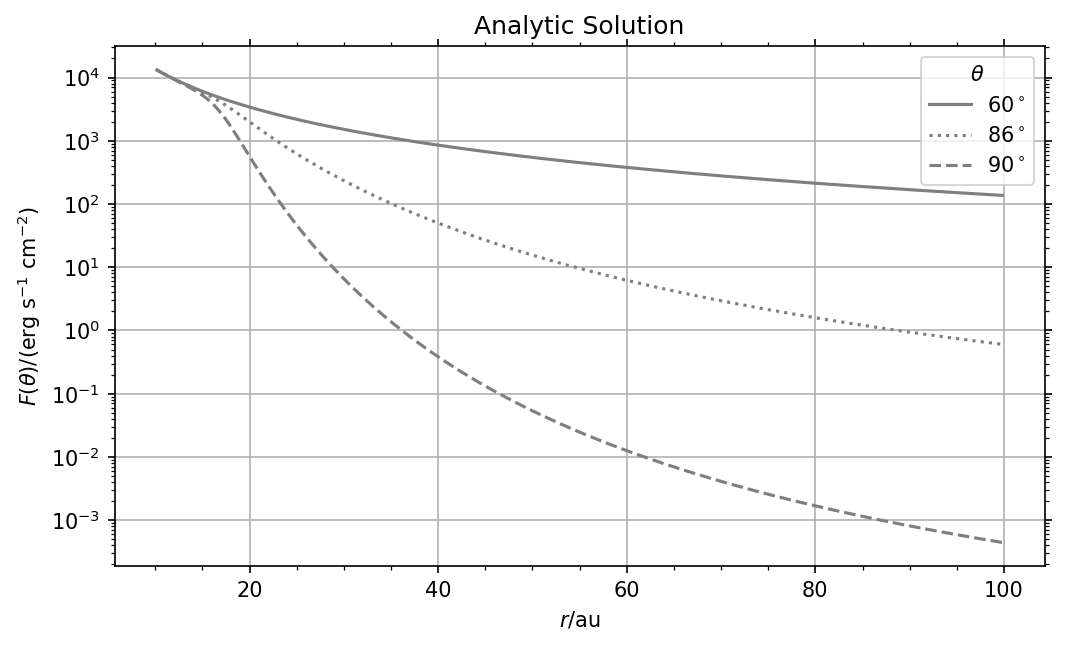

In [8]:
#===============================================================================
# Plot cuts
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=150)
dtheta = (x2max - x2min)/nx2
theta_degs = [60, 86, 90]
rad2deg = 180/np.pi
lss = ['solid', 'dotted', 'dashed', 'dashdot']

for th, theta_deg in enumerate(theta_degs):
  j = int(theta_deg/rad2deg/dtheta)
  ax.plot(x1v*L_au, F[j, :], color='tab:gray', ls=lss[th],
          label=rf'{theta_deg}$^\circ$')

# Format (sub)plots
ax.grid()
ax.legend(title=r'$\theta$')
ax.minorticks_on()
ax.set(title='Analytic Solution', xlabel='$r$/au', yscale='log',
       ylabel=r'$F(\theta)/($erg s$^{-1}$ cm$^{-2}$)')
ax.tick_params(axis='both', which='both', top=True, right=True)
# plt.savefig('figs/frame.jpg', bbox_inches='tight')

In [9]:
print(f'F(10 au) = {F[j, 0]:.1e} erg/cm^2/s = {F[j, 0]/1e3:.02f} W/m^2')

F(10 au) = 1.3e+04 erg/cm^2/s = 13.17 W/m^2


## Athena++

### `sigma_pe = 0` vs. `sigma_pe = sigma_a`

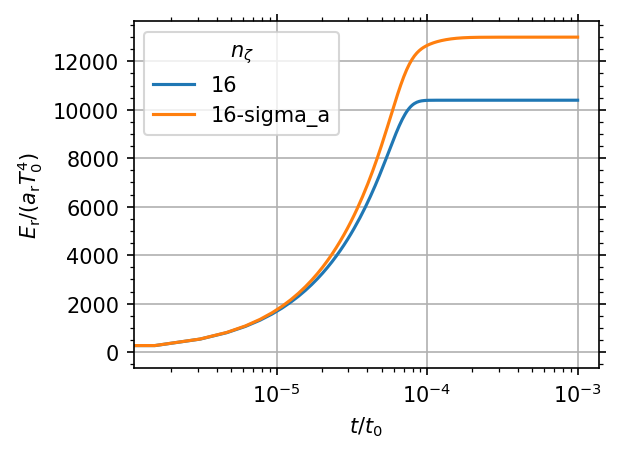

In [10]:
#==============================================================================
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read
import matplotlib.pyplot as plt

problem_id = 'pseudo_ray_tracing'
nzetas = ['16', '16-sigma_a']#, 128, 1024]
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)

# Read and plot
for z, nzeta in enumerate(nzetas):
    path = f'nzeta{nzeta}'
    hst = athena_read.hst(f'{path}/output/{problem_id}.hst')

    ax.semilogx(hst['time'], hst['Er'], label=nzeta)

# Format (sub)plots
ax.grid()
ax.legend(title=r'$n_\zeta$')
ax.minorticks_on()
ax.set(xlabel='$t/t_0$', ylabel=r'$E_\mathrm{r}/(a_\mathrm{r}T_0^4$)')
ax.tick_params(axis='both', which='both', top=True, right=True)
# plt.savefig(f'NAME.jpg', bbox_inches='tight', pad_inches=0.01)

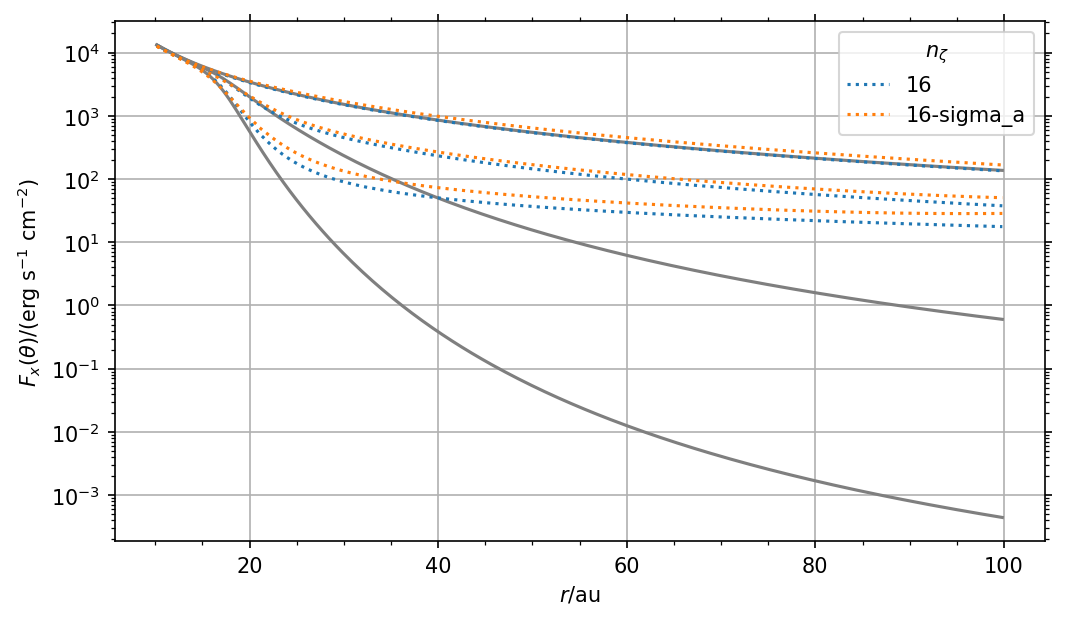

In [11]:
#===============================================================================
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read
import matplotlib.pyplot as plt
import numpy as np

# conversions
au = 1.495978707e13 # [cm]
rad2deg = 180/np.pi

problem_id = 'pseudo_ray_tracing'
nzetas = ['16', '16-sigma_a']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
          'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']
theta_degs = [60, 86, 90]
dtheta = (x2max - x2min)/nx2
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=150)

# Plot analytic solution
for theta_deg in theta_degs:
    j = int(theta_deg/rad2deg/dtheta)
    ax.plot(x1v*L_au, F[j, :], color='tab:gray')

# Read and plot Athena++ solutions
for z, nzeta in enumerate(nzetas):
    path = f'nzeta{nzeta}'
    athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
    length_unit = athinput['radiation']['length_unit']
    L_au = length_unit/au
    dtheta = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])\
            /athinput['mesh']['nx2']
    athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf')
    Fr1 = athdf['Fr1'][0]

    for theta_deg in theta_degs:
        j = int(theta_deg/rad2deg/dtheta)
        ax.plot(athdf['x1v']*L_au, Fr1[j, :], ':', color=colors[z])

    ax.plot([], [], ':', color=colors[z], label=f'{nzeta}')

# Format (sub)plots
ax.grid()
ax.legend(title=r'$n_\zeta$')
ax.minorticks_on()
ax.set(xlabel='$r$/au', yscale='log', #ylim=(2e-4, 2e4),
       ylabel=r'$F_x(\theta)/($erg s$^{-1}$ cm$^{-2}$)')
ax.tick_params(axis='both', which='both', top=True, right=True)
# plt.savefig('figs/frame.jpg', bbox_inches='tight')

### Angular Resolution Study

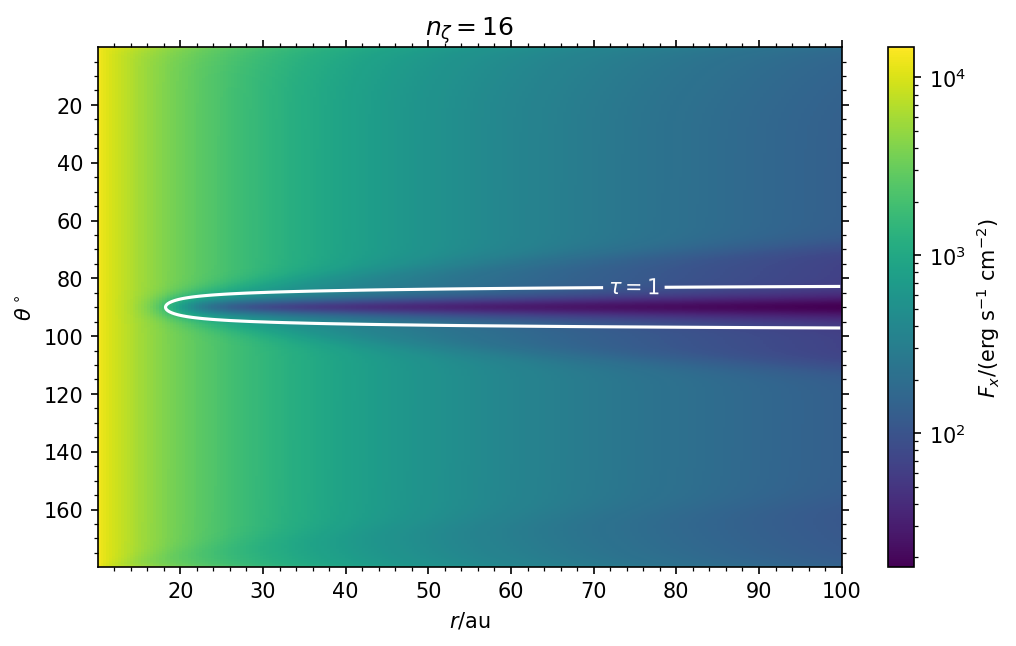

In [12]:
#===============================================================================
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def fmt(x):
  return rf'$\tau={x:.0f}$'

# conversions
au = 1.495978707e13 # [cm]
rad2deg = 180/np.pi

problem_id = 'pseudo_ray_tracing'
nzeta = 16
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=150)

# Read and plot
path = f'nzeta{nzeta}'
athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
length_unit = athinput['radiation']['length_unit']
L_au = length_unit/au
athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf')
Fr1 = athdf['Fr1'][0]
im = ax.pcolormesh(athdf['x1v']*L_au, athdf['x2v']*rad2deg, Fr1,
                   norm=colors.LogNorm())
dr = (athinput['mesh']['x1max'] - athinput['mesh']['x1min'])\
     /athinput['mesh']['nx1']
dtau = athdf['Sigma_a_0'][0]*dr
tau_field  = np.cumsum(dtau, axis=1)
CS = ax.contour(athdf['x1v']*L_au, athdf['x2v']*rad2deg, tau_field, [1, 1e4],
                colors=['white', 'white'])

# Format (sub)plots
plt.colorbar(im, label='$F_x$/(erg s$^{-1}$ cm$^{-2}$)')
ax.clabel(CS, CS.levels, fmt=fmt)
ax.invert_yaxis()
ax.minorticks_on()
ax.set(title=rf'$n_\zeta={nzeta}$',
       xlabel='$r$/au', ylabel=r'$\theta^\circ$')
ax.tick_params(axis='both', which='both', top=True, right=True)
# plt.savefig(f'{path}/temp/Fr1({t:.2f}t_0).jpg', bbox_inches='tight')

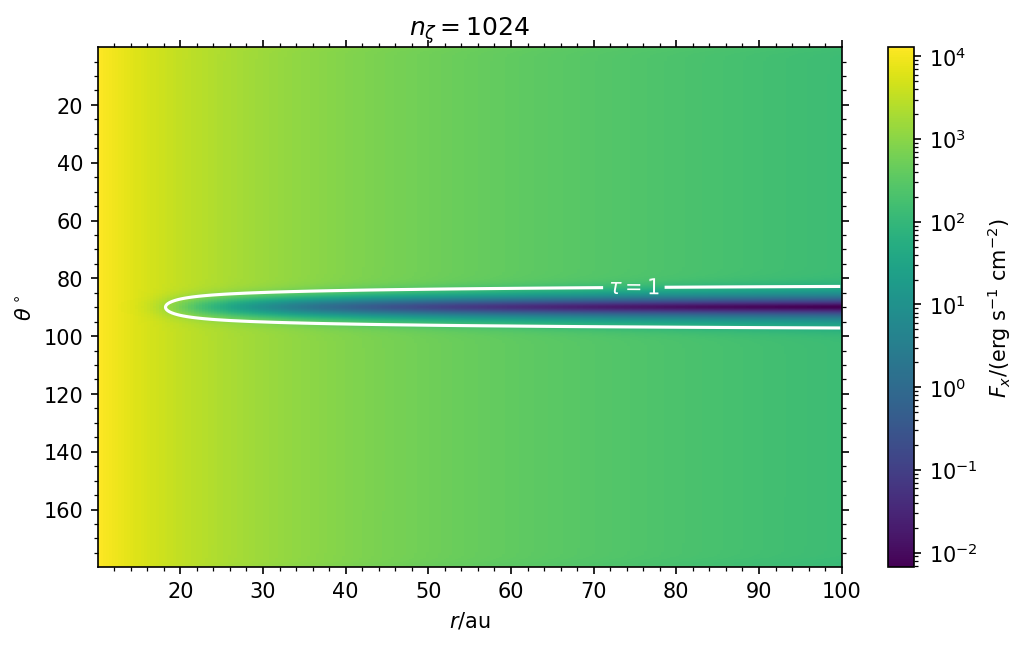

In [13]:
#===============================================================================
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def fmt(x):
  return rf'$\tau={x:.0f}$'

# conversions
au = 1.495978707e13 # [cm]
rad2deg = 180/np.pi

problem_id = 'pseudo_ray_tracing'
nzeta = 1024
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=150)

# Read and plot
path = f'nzeta{nzeta}'
athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
length_unit = athinput['radiation']['length_unit']
L_au = length_unit/au
athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf')
Fr1 = athdf['Fr1'][0]
im = ax.pcolormesh(athdf['x1v']*L_au, athdf['x2v']*rad2deg, Fr1,
                   norm=colors.LogNorm())
dr = (athinput['mesh']['x1max'] - athinput['mesh']['x1min'])\
     /athinput['mesh']['nx1']
dtau = athdf['Sigma_a_0'][0]*dr
tau_field  = np.cumsum(dtau, axis=1)
CS = ax.contour(athdf['x1v']*L_au, athdf['x2v']*rad2deg, tau_field, [1, 1e4],
                colors=['white', 'white'])

# Format (sub)plots
plt.colorbar(im, label='$F_x$/(erg s$^{-1}$ cm$^{-2}$)')
ax.clabel(CS, CS.levels, fmt=fmt)
ax.invert_yaxis()
ax.minorticks_on()
ax.set(title=rf'$n_\zeta={nzeta}$',
       xlabel='$r$/au', ylabel=r'$\theta^\circ$')
ax.tick_params(axis='both', which='both', top=True, right=True)
# plt.savefig(f'{path}/temp/Fr1({t:.2f}t_0).jpg', bbox_inches='tight')

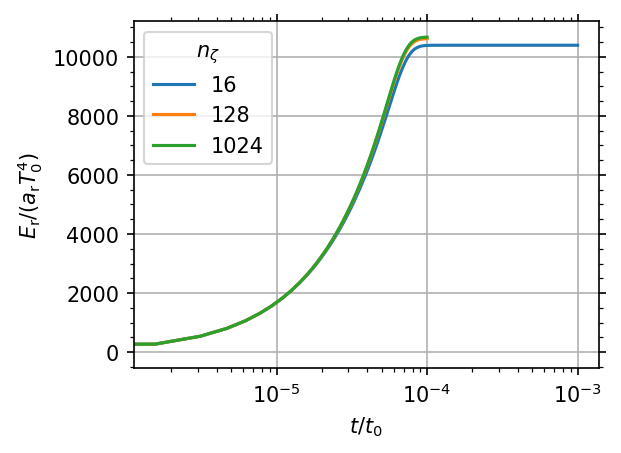

In [14]:
#==============================================================================
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read
import matplotlib.pyplot as plt

problem_id = 'pseudo_ray_tracing'
nzetas = [16, 128, 1024]
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)

# Read and plot
for z, nzeta in enumerate(nzetas):
    path = f'nzeta{nzeta}'
    hst = athena_read.hst(f'{path}/output/{problem_id}.hst')

    ax.semilogx(hst['time'], hst['Er'], label=nzeta)

# Format (sub)plots
ax.grid()
ax.legend(title=r'$n_\zeta$')
ax.minorticks_on()
ax.set(xlabel='$t/t_0$', ylabel=r'$E_\mathrm{r}/(a_\mathrm{r}T_0^4$)')
ax.tick_params(axis='both', which='both', top=True, right=True)
# plt.savefig(f'NAME.jpg', bbox_inches='tight', pad_inches=0.01)

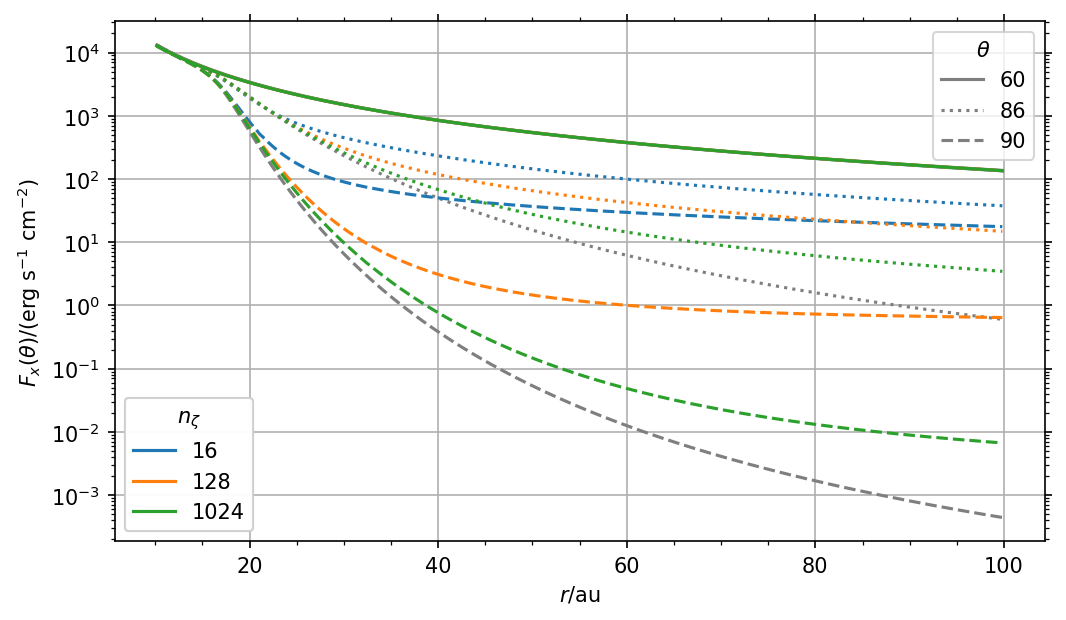

In [15]:
#===============================================================================
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read
import matplotlib.pyplot as plt
import numpy as np

# conversions
au = 1.495978707e13 # [cm]
rad2deg = 180/np.pi

problem_id = 'pseudo_ray_tracing'
nzetas = [16, 128, 1024]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
          'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']
theta_degs = [60, 86, 90]
lss = ['solid', 'dotted', 'dashed', 'dashdot']
ls_thetas, ls_nzetas = [], []
dtheta = (x2max - x2min)/nx2
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=150)

# Plot analytic solution
for th, theta_deg in enumerate(theta_degs):
    j = int(theta_deg/rad2deg/dtheta)
    ax.plot(x1v*L_au, F[j, :], color='tab:gray', ls=lss[th])

# Read and plot Athena++ solutions
for z, nzeta in enumerate(nzetas):
    path = f'nzeta{nzeta}'
    athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
    length_unit = athinput['radiation']['length_unit']
    L_au = length_unit/au
    dtheta = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])\
            /athinput['mesh']['nx2']
    athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf')
    Fr1 = athdf['Fr1'][0]

    for th, theta_deg in enumerate(theta_degs):
        j = int(theta_deg/rad2deg/dtheta)
        ax.plot(athdf['x1v']*L_au, Fr1[j, :], ls=lss[th], color=colors[z])
        
        if z == 0:
            ls_thetas.append(ax.plot([], [], color='tab:gray', label=theta_deg, ls=lss[th])[0])

    # Plot ghost points for colorless line style and add legends
    ls_nzetas.append(ax.plot([], [], color=colors[z], label=nzeta)[0])

ls_legend = plt.legend(title=r'$\theta$', handles=ls_thetas, loc='upper right')
color_legend = plt.legend(title=r'$n_\zeta$', handles=ls_nzetas, loc='lower left')
ax.add_artist(ls_legend)
ax.add_artist(color_legend)

# Format (sub)plots
ax.grid()
ax.minorticks_on()
ax.set(xlabel='$r$/au', yscale='log', #ylim=(2e-4, 2e4),
       ylabel=r'$F_x(\theta)/($erg s$^{-1}$ cm$^{-2}$)')
ax.tick_params(axis='both', which='both', top=True, right=True)
# plt.savefig('figs/frame.jpg', bbox_inches='tight')

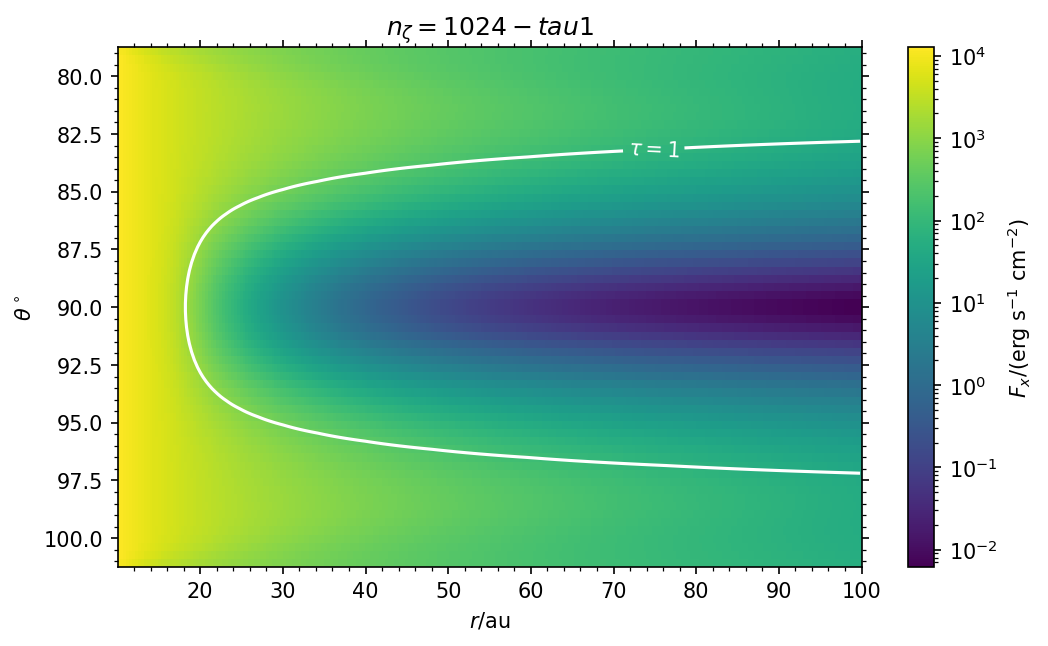

In [16]:
#===============================================================================
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def fmt(x):
  return rf'$\tau={x:.0f}$'

# conversions
au = 1.495978707e13 # [cm]
rad2deg = 180/np.pi

problem_id = 'pseudo_ray_tracing'
nzeta = '1024-tau1'
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=150)

# Read and plot
path = f'nzeta{nzeta}'
athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
length_unit = athinput['radiation']['length_unit']
L_au = length_unit/au
athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf')
Fr1 = athdf['Fr1'][0]
im = ax.pcolormesh(athdf['x1v']*L_au, athdf['x2v']*rad2deg, Fr1,
                   norm=colors.LogNorm())
dr = (athinput['mesh']['x1max'] - athinput['mesh']['x1min'])\
     /athinput['mesh']['nx1']
dtau = athdf['Sigma_a_0'][0]*dr
tau_field  = np.cumsum(dtau, axis=1)
CS = ax.contour(athdf['x1v']*L_au, athdf['x2v']*rad2deg, tau_field, [1, 1e4],
                colors=['white', 'white'])

# Format (sub)plots
plt.colorbar(im, label='$F_x$/(erg s$^{-1}$ cm$^{-2}$)')
ax.clabel(CS, CS.levels, fmt=fmt)
ax.invert_yaxis()
ax.minorticks_on()
ax.set(title=rf'$n_\zeta={nzeta}$',
       xlabel='$r$/au', ylabel=r'$\theta^\circ$')
ax.tick_params(axis='both', which='both', top=True, right=True)
# plt.savefig(f'{path}/temp/Fr1({t:.2f}t_0).jpg', bbox_inches='tight')

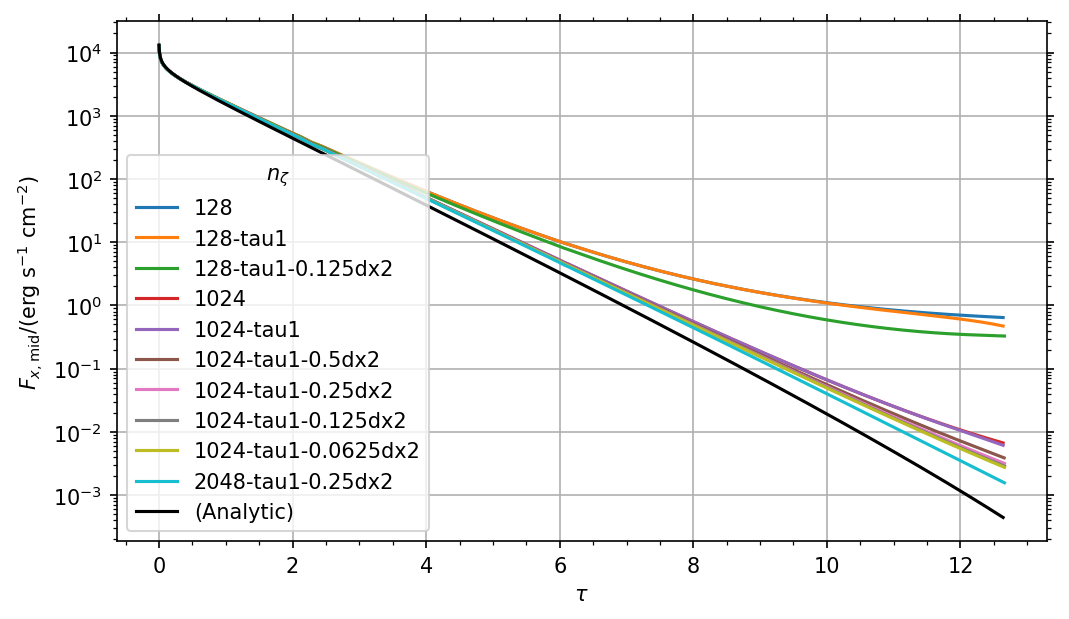

In [17]:
#===============================================================================
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read
import matplotlib.pyplot as plt
import numpy as np

# conversions
au = 1.495978707e13 # [cm]
rad2deg = 180/np.pi

problem_id = 'pseudo_ray_tracing'
nzetas = ['128', '128-tau1', '128-tau1-0.125dx2',
          '1024', '1024-tau1', '1024-tau1-0.5dx2',
          '1024-tau1-0.25dx2', '1024-tau1-0.125dx2',
          '1024-tau1-0.0625dx2', '2048-tau1-0.25dx2']
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=150)

# Read and plot Athena++ solutions
for z, nzeta in enumerate(nzetas):
    path = f'nzeta{nzeta}'
    athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
    length_unit = athinput['radiation']['length_unit']
    L_au = length_unit/au
    athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf')
    Fr1 = athdf['Fr1'][0]
    dr = (athinput['mesh']['x1max'] - athinput['mesh']['x1min'])\
         /athinput['mesh']['nx1']
    dtau = athdf['Sigma_a_0'][0]*dr
    tau_field  = np.cumsum(dtau, axis=1)
    j_mid = athinput['mesh']['nx2']//2
    ax.plot(tau_field[j_mid, :], Fr1[j_mid, :], label=nzeta)

# Plot analytic solution
j_mid = nx2//2
ax.plot(tau[j_mid, :], F[j_mid, :], color='black', label='(Analytic)')

# Format (sub)plots
ax.grid()
ax.legend(title=r'$n_\zeta$')
ax.minorticks_on()
ax.set(xlabel=r'$\tau$', yscale='log', #xscale='log',
       ylabel=r'$F_{x,\mathrm{mid}}/($erg s$^{-1}$ cm$^{-2}$)')
ax.tick_params(axis='both', which='both', top=True, right=True)
# plt.savefig('figs/frame.jpg', bbox_inches='tight')

In [18]:
import numpy as np

dtheta = np.pi/512
print(f'x2min = {np.pi/2 - 32*dtheta}')
print(f'x2max = {np.pi/2 + 32*dtheta}')


x2min = 1.3744467859455345
x2max = 1.7671458676442586


In [19]:
256*256/32/32

64.0

## Appendix

In [20]:
npsi = 2
nzeta = 80
path = f'npsi{npsi}/nzeta{nzeta}'
uov = athena_read.athdf(f'{path}/athdf/{problem_id}.out3.00001.athdf')
nang = 24

for j in range(nx2):
    nact = 0

    for n in range(nang):  
        if uov[f'user_out_var{n}'][0,j,0] > 0: nact += 1
    
    print(f'nact(j = {j}) = {nact}')

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'npsi2/nzeta80/athdf/pseudo_ray_tracing.out3.00001.athdf', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
npsi = 4
nzeta = 40
path = f'npsi{npsi}/nzeta{nzeta}'
uov = athena_read.athdf(f'{path}/athdf/{problem_id}.out3.00001.athdf')
nang = 24

for j in range(nx2):
    nact = 0

    for n in range(nang):  
        if uov[f'user_out_var{n}'][0,j,0] > 0: nact += 1
    
    print(f'nact(j = {j}) = {nact}')